In [1]:
"""
Shor's Order Finding Algorithm Benchmark - Qiskit
"""

import math
import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from shors_utils import getAngles, getAngle, modinv, generate_base
import matplotlib.pyplot as plt

from qiskit import *
# Benchmark Name
benchmark_name = "Shor's Order Finding"

# Noise parameters
options = { } #if Noise is None

options_noisy = { #if Noise is not None
    'plot': False,
    "thermal_factor": 0.0,
    'show_partition': False,
    "decoherence_factor": 0.9,
    "depolarization_factor": 0.9,
    "bell_depolarization_factor": 0.9,
    "decay_factor": 0.9,
    "rotation_error": {'rx':[1.0, 0.0], 'ry':[1.0, 0.0], 'rz':[1.0, 0.0]},
    "tsp_model_error": [1.0, 0.0],
}

# Selection of basis gate set for transpilation
# Note: selector 1 is a hardware agnostic gate set
basis_selector = 1
basis_gates_array = [
    [],
    ['rx', 'ry', 'rz', 'cx'],       # a common basis set, default
    ['cx', 'rz', 'sx', 'x'],        # IBM default basis set
    ['rx', 'ry', 'rxx'],            # IonQ default basis set
    ['h', 'p', 'cx'],               # another common basis set
    ['u', 'cx']                     # general unitaries basis gates
]

np.random.seed(0)

verbose = False

QC_ = None
PHIADD_ = None
CCPHIADDMODN_ = None
CMULTAMODN_ = None
CUA_ = None
QFT_ = None
QFTI_ = None

In [2]:
num_gates = 0
depth = 0
############### QFT Circuit

def qft_gate(input_size):
    global QFT_, num_gates, depth
    qr = QuantumRegister(input_size); qc = QuantumCircuit(qr, name="qft")
    
    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in range(0, input_size):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in range(0, num_crzs):
                divisor = 2 ** (num_crzs - j)
                qc.crz( math.pi / divisor , qr[hidx], qr[input_size - j - 1])
                num_gates += 1
                depth += 1
            
        # followed by an H gate (applied to all qubits)
        qc.h(qr[hidx])
        num_gates += 1
        depth += 1
        
        qc.barrier()
    
    if QFT_ == None or input_size <= 5:
        if input_size < 9: QFT_ = qc
        
    return qc

############### Inverse QFT Circuit

def inv_qft_gate(input_size):
    global QFTI_, num_gates, depth
    qr = QuantumRegister(input_size); qc = QuantumCircuit(qr, name="inv_qft")
    
    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in reversed(range(0, input_size)):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # precede with an H gate (applied to all qubits)
        qc.h(qr[hidx])
        num_gates += 1
        depth += 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in reversed(range(0, num_crzs)):
                divisor = 2 ** (num_crzs - j)
                qc.crz( -math.pi / divisor , qr[hidx], qr[input_size - j - 1])
                num_gates += 1
                depth += 1
            
        qc.barrier()  
    
    if QFTI_ == None or input_size <= 5:
        if input_size < 9: QFTI_= qc
        
    return qc

In [3]:
############### Circuit Definition

#Creation of the circuit that performs addition by a in Fourier Space
#Can also be used for subtraction by setting the parameter inv to a value different from 0
def phiADD(num_qubits, a):

    qc = QuantumCircuit(num_qubits, name = "\u03C6ADD")

    angle = getAngles(a, num_qubits)
    for i in range(0, num_qubits):
        # addition
        qc.p(angle[i], i)

    global PHIADD_
    if PHIADD_ == None or num_qubits <= 3:
        if num_qubits < 4: PHIADD_ = qc

    return qc

#Single controlled version of the phiADD circuit
def cphiADD(num_qubits, a):
    phiadd_gate = phiADD(num_qubits,a).to_gate()
    cphiadd_gate = phiadd_gate.control(1)
    return cphiadd_gate

#Doubly controlled version of the phiADD circuit
def ccphiADD(num_qubits, a):
    phiadd_gate = phiADD(num_qubits,a).to_gate()
    ccphiadd_gate = phiadd_gate.control(2)
    return ccphiadd_gate

# Circuit that implements doubly controlled modular addition by a (num qubits should be bit count for number N)
def ccphiADDmodN(num_qubits, a, N):
    qr_ctl = QuantumRegister(2)
    qr_main = QuantumRegister(num_qubits+1)
    qr_ancilla = QuantumRegister(1)
    qc = QuantumCircuit(qr_ctl, qr_main,qr_ancilla, name = "cc\u03C6ADDmodN")

    # Generate relevant gates for circuit
    ccphiadda_gate = ccphiADD(num_qubits+1, a)
    ccphiadda_inv_gate = ccphiADD(num_qubits+1, a).inverse()
    phiaddN_inv_gate = phiADD(num_qubits+1, N).inverse(); phiaddN_inv_gate.name = "inv_\u03C6ADD"
    cphiaddN_gate = cphiADD(num_qubits+1, N)

    # Create relevant temporary qubit lists
    ctl_main_qubits = [i for i in qr_ctl]; ctl_main_qubits.extend([i for i in qr_main])
    anc_main_qubits = [qr_ancilla[0]]; anc_main_qubits.extend([i for i in qr_main])

    #Create circuit
    qc.append(ccphiadda_gate, ctl_main_qubits)
    qc.append(phiaddN_inv_gate, qr_main)

    qc.append(inv_qft_gate(num_qubits+1), qr_main)
    qc.cx(qr_main[-1], qr_ancilla[0])
    qc.append(qft_gate(num_qubits+1), qr_main)

    qc.append(cphiaddN_gate, anc_main_qubits)
    qc.append(ccphiadda_inv_gate, ctl_main_qubits)

    qc.append(inv_qft_gate(num_qubits+1), qr_main)

    qc.x(qr_main[-1])
    qc.cx(qr_main[-1], qr_ancilla[0])
    qc.x(qr_main[-1])

    qc.append(qft_gate(num_qubits+1), qr_main)

    qc.append(ccphiadda_gate, ctl_main_qubits)

    global CCPHIADDMODN_
    if CCPHIADDMODN_ == None or num_qubits <= 2:
        if num_qubits < 3: CCPHIADDMODN_ = qc

    return qc

# Circuit that implements the inverse of doubly controlled modular addition by a
def ccphiADDmodN_inv(num_qubits, a, N):
    cchpiAddmodN_circ = ccphiADDmodN(num_qubits, a, N)
    cchpiAddmodN_inv_circ = cchpiAddmodN_circ.inverse()
    cchpiAddmodN_inv_circ.name = "inv_cchpiAddmodN"
    return  cchpiAddmodN_inv_circ

# Creates circuit that implements single controlled modular multiplication by a. n represents the number of bits
# needed to represent the integer number N
def cMULTamodN(n, a, N):
    qr_ctl = QuantumRegister(1)
    qr_x = QuantumRegister(n)
    qr_main = QuantumRegister(n+1)
    qr_ancilla = QuantumRegister(1)
    qc = QuantumCircuit(qr_ctl, qr_x, qr_main,qr_ancilla, name = "cMULTamodN")

    # quantum Fourier transform only on auxillary qubits
    qc.append(qft_gate(n+1), qr_main)

    for i in range(n):
        ccphiADDmodN_gate = ccphiADDmodN(n, (2**i)*a % N, N)

        # Create relevant temporary qubit list
        qubits = [qr_ctl[0]]; qubits.extend([qr_x[i]])
        qubits.extend([i for i in qr_main]); qubits.extend([qr_ancilla[0]])

        qc.append(ccphiADDmodN_gate, qubits)

    # inverse quantum Fourier transform only on auxillary qubits
    qc.append(inv_qft_gate(n+1), qr_main)

    global CMULTAMODN_
    if CMULTAMODN_ == None or n <= 2:
        if n < 3: CMULTAMODN_ = qc

    return qc

# Creates circuit that implements single controlled Ua gate. n represents the number of bits
# needed to represent the integer number N
def controlled_Ua(n,a,exponent,N):
    qr_ctl = QuantumRegister(1)
    qr_x = QuantumRegister(n)
    qr_main = QuantumRegister(n)
    qr_ancilla = QuantumRegister(2)
    qc = QuantumCircuit(qr_ctl, qr_x, qr_main,qr_ancilla, name = f"C-U^{a**exponent}")

    # Generate Gates
    a_inv = modinv(a**exponent,N)
    cMULTamodN_gate = cMULTamodN(n, a**exponent, N)
    cMULTamodN_inv_gate = cMULTamodN(n, a_inv, N).inverse(); cMULTamodN_inv_gate.name = "inv_cMULTamodN"

    # Create relevant temporary qubit list
    qubits = [i for i in qr_ctl]; qubits.extend([i for i in qr_x]); qubits.extend([i for i in qr_main])
    qubits.extend([i for i in qr_ancilla])

    qc.append(cMULTamodN_gate, qubits)

    for i in range(n):
        qc.cswap(qr_ctl, qr_x[i], qr_main[i])

    qc.append(cMULTamodN_inv_gate, qubits)

    global CUA_
    if CUA_ == None or n <= 2:
        if n < 3: CUA_ = qc

    return qc

# Execute Shor's Order Finding Algorithm given a 'number' to factor,
# the 'base' of exponentiation, and the number of qubits required 'input_size'

def ShorsAlgorithm(number, base, method, verbose=verbose):
    
    # Create count of qubits to use to represent the number to factor
    # NOTE: this should match the number of bits required to represent (number)
    n = int(math.ceil(math.log(number, 2)))
    # Standard Shors Algorithm
    if method == 1:
        num_qubits = 4*n + 2

        if verbose:
            print(f"... running Shors to find order of [ {base}^x mod {number} ] using num_qubits={num_qubits}")

        # Create a circuit and allocate necessary qubits
        qr_counting = QuantumRegister(2*n)        # Register for sequential QFT
        qr_mult = QuantumRegister(n)        # Register for multiplications
        qr_aux = QuantumRegister(n+2)       # Register for addition and multiplication
        cr_data = ClassicalRegister(2*n)  # Register for measured values of QFT
        qc = QuantumCircuit(qr_counting, qr_mult, qr_aux, cr_data,
                name=f"qmc({method})-{num_qubits}-{number}")

        # Initialize multiplication register to 1 and counting register to superposition state
        qc.h(qr_counting)
        qc.x(qr_mult[0])

        qc.barrier()

        # Apply Multiplication Gates for exponentiation
        for i in reversed(range(2*n)):
            cUa_gate = controlled_Ua(n,int(base),2**(2*n-1-i),number)

            # Create relevant temporary qubit list
            qubits = [qr_counting[i]]; qubits.extend([i for i in qr_mult]);qubits.extend([i for i in qr_aux])

            qc.append(cUa_gate, qubits)

        qc.barrier()

        qc.append(inv_qft_gate(2*n),qr_counting)

        # Measure counting register
        qc.measure(qr_counting, cr_data)

    elif method == 2:

        # Create a circuit and allocate necessary qubits
        num_qubits = 2*n + 3

        if verbose:
            print(f"... running Shors to find order of [ {base}^x mod {number} ] using num_qubits={num_qubits}")

        qr_counting = QuantumRegister(1)        # Single qubit for sequential QFT
        qr_mult = QuantumRegister(n)      # Register for multiplications
        qr_aux = QuantumRegister(n+2)     # Register for addition and multiplication
        cr_data = ClassicalRegister(2*n)  # Register for measured values of QFT
        cr_aux = ClassicalRegister(1)     # Register to reset the state of the up register based on previous measurements
        qc = QuantumCircuit(qr_counting, qr_mult, qr_aux, cr_data, cr_aux, name="main")

        # Initialize mult register to 1
        qc.x(qr_mult[0])

        # perform modular exponentiation 2*n times
        for k in range(2*n):
            qc.barrier()

            # Reset the counting qubit to 0 if the previous measurement was 1
            qc.x(qr_counting).c_if(cr_aux,1)
            qc.h(qr_counting)

            cUa_gate = controlled_Ua(n, base,2**(2*n-1-k), number)

            # Create relevant temporary qubit list
            qubits = [qr_counting[0]]; qubits.extend([i for i in qr_mult]);qubits.extend([i for i in qr_aux])

            qc.append(cUa_gate, qubits)

            # perform inverse QFT --> Rotations conditioned on previous outcomes
            for i in range(2**k):
                qc.p(getAngle(i, k), qr_counting[0]).c_if(cr_data, i)

            qc.h(qr_counting)
            qc.measure(qr_counting[0], cr_data[k])
            qc.measure(qr_counting[0], cr_aux[0])
    
    global QC_, QFT_
    if QC_ == None or n <= 2:
        if n < 3: QC_ = qc
    if QFT_ == None or n <= 2:
        if n < 3: QFT_ = qft_gate(n+1)

    return qc

############### Circuit end

def expected_shor_dist(num_bits, order, num_shots):
    # num_bits represent the number of bits to represent the number N in question

    # Qubits measureed always 2 * num_bits for the three methods implemented in this benchmark
    qubits_measured = 2 * num_bits
    dist = {}

    #Conver float to int
    r = int(order)

    #Generate expected distribution
    q = int(2 ** (qubits_measured))

    for i in range(r):
        key = bin(int(q*(i/r)))[2:].zfill(qubits_measured)
        dist[key] = num_shots/r

        '''
            for c in range(2 ** qubits_measured):
                key = bin(c)[2:].zfill(qubits_measured)
                amp = 0
                for i in range(int(q/r) - 1):
                    amp += np.exp(2*math.pi* 1j * i * (r * c % q)/q )
                amp = amp * np.sqrt(r) / q
                dist[key] = abs(amp) ** 2
        '''
    return dist


In [4]:
############################################
# DATA ANALYSIS - FIDELITY CALCULATIONS

## Uniform distribution function commonly used
def rescale_fidelity(fidelity, floor_fidelity, new_floor_fidelity):
    """
    Linearly rescales our fidelities to allow comparisons of fidelities across benchmarks
    
    fidelity: raw fidelity to rescale
    floor_fidelity: threshold fidelity which is equivalent to random guessing
    new_floor_fidelity: what we rescale the floor_fidelity to 

    Ex, with floor_fidelity = 0.25, new_floor_fidelity = 0.0:
        1 -> 1;
        0.25 -> 0;
        0.5 -> 0.3333;
    """
    rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1
    
    # ensure fidelity is within bounds (0, 1)
    if rescaled_fidelity < 0:
        rescaled_fidelity = 0.0
    if rescaled_fidelity > 1:
        rescaled_fidelity = 1.0
    
    return rescaled_fidelity
    
def uniform_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = 1/(2**num_state_qubits)
    return dist                

### Analysis methods to be expanded and eventually compiled into a separate analysis.py file
import math, functools

def hellinger_fidelity_with_expected(p, q):
    """ p: result distribution, may be passed as a counts distribution
        q: the expected distribution to be compared against

    References:
        `Hellinger Distance @ wikipedia <https://en.wikipedia.org/wiki/Hellinger_distance>`_
        Qiskit Hellinger Fidelity Function
    """
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    if q_sum == 0:
        print("ERROR: polarization_fidelity(), expected distribution is invalid, all counts equal to 0")
        return 0

    p_normed = {}
    for key, val in p.items():
        p_normed[key] = val/p_sum
        # if p_sum != 0:
        #     p_normed[key] = val/p_sum
        # else:
        #     p_normed[key] = 0

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val/q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key]))**2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())
    
    # in some situations (error mitigation) this can go negative, use abs value
    if total < 0:
        print(f"WARNING: using absolute value in fidelity calculation")
        total = abs(total)
        
    dist = np.sqrt(total)/np.sqrt(2)
    fidelity = (1-dist**2)**2

    return fidelity

def polarization_fidelity(counts, correct_dist, thermal_dist=None):
    """
    Combines Hellinger fidelity and polarization rescaling into fidelity calculation
    used in every benchmark

    counts: the measurement outcomes after `num_shots` algorithm runs
    correct_dist: the distribution we expect to get for the algorithm running perfectly
    thermal_dist: optional distribution to pass in distribution from a uniform
                  superposition over all states. If `None`: generated as 
                  `uniform_dist` with the same qubits as in `counts`
                  
    returns both polarization fidelity and the hellinger fidelity

    Polarization from: `https://arxiv.org/abs/2008.11294v1`
    """
    #print("in polarization fidelity:",correct_dist)
    num_measured_qubits = len(list(correct_dist.keys())[0])
    print(num_measured_qubits)
    
    counts = {k.zfill(num_measured_qubits): v for k, v in counts.items()}
    
    # calculate hellinger fidelity between measured expectation values and correct distribution
    hf_fidelity = hellinger_fidelity_with_expected(counts,correct_dist)
    
    # to limit cpu and memory utilization, skip noise correction if more than 16 measured qubits
    if num_measured_qubits > 16:
        return { 'fidelity':hf_fidelity, 'hf_fidelity':hf_fidelity }

    # if not provided, generate thermal dist based on number of qubits
    if thermal_dist == None:
        thermal_dist = uniform_dist(num_measured_qubits)

    # set our fidelity rescaling value as the hellinger fidelity for a depolarized state
    floor_fidelity = hellinger_fidelity_with_expected(thermal_dist, correct_dist)

    # rescale fidelity result so uniform superposition (random guessing) returns fidelity
    # rescaled to 0 to provide a better measure of success of the algorithm (polarization)
    new_floor_fidelity = 0
    fidelity = rescale_fidelity(hf_fidelity, floor_fidelity, new_floor_fidelity)

    return { 'fidelity':fidelity, 'hf_fidelity':hf_fidelity }

In [5]:
# Function to calculate circuit depth
def calculate_circuit_depth(qc):
    # Calculate the depth of the circuit
    depth = qc.depth()
    return depth

def calculate_transpiled_depth(qc,basis_selector):
    # use either the backend or one of the basis gate sets
    if basis_selector == 0:
        qc = transpile(qc, backend)
        
    else:
        basis_gates = basis_gates_array[basis_selector]
        qc = transpile(qc, basis_gates=basis_gates, seed_transpiler=0)
    transpiled_depth = qc.depth()
    return transpiled_depth

def plot_data(fidelity_data, Hf_fidelity_data, title):
    avg_fidelity_means = []
    avg_Hf_fidelity_means = []
    avg_num_qubits_values = list(fidelity_data.keys())
    print("avg_num_qubits_values",avg_num_qubits_values)
    # Calculate the average fidelity and Hamming fidelity for each unique number of qubits
    for num_qubits in avg_num_qubits_values:
        avg_fidelity = np.average(fidelity_data[num_qubits])
        avg_fidelity_means.append(avg_fidelity)

        avg_Hf_fidelity = np.mean(Hf_fidelity_data[num_qubits])
        avg_Hf_fidelity_means.append(avg_Hf_fidelity)
    
    

    # Plot the data
    x = np.arange(len(avg_num_qubits_values))
    
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects2 =ax.bar(x, avg_Hf_fidelity_means, width=0.4, label='Hellinger Fidelity',color="magenta")
    rects1 = ax.bar(x, avg_fidelity_means, width=0.2, label='Normalized Fidelity', color="blue")
    
    ax.set_xlabel('Number of Qubits')
    ax.set_ylabel('Average Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(avg_num_qubits_values)
    ax.legend()
    
    # Add labels to the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.5f}'.format(height),  # Formatting to two decimal places
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.show()
    print(fidelity_data)
    print(Hf_fidelity_data)
    print(avg_fidelity_means)
    print(avg_Hf_fidelity_means)

Shor's Order Finding (1) Benchmark - Qiskit
************
Executing [1] circuits with num_qubits = 10
qc of 10 qubits of type <class 'type'>
            ░ ┌────────┐┌────────┐┌─────────┐┌──────────┐ ░                   »
q2_0: ──────░─┤6       ├┤6       ├┤6        ├┤6         ├─░───────────────────»
            ░ │        ││        ││         ││          │ ░                   »
q2_1: ──────░─┤5       ├┤5       ├┤5        ├┤5         ├─░───────────────────»
            ░ │        ││        ││         ││          │ ░                   »
q2_2: ──────░─┤4       ├┤4       ├┤4        ├┤4         ├─░───────────────────»
            ░ │        ││        ││         ││          │ ░                   »
q2_3: ──────░─┤3 C-U^2 ├┤3       ├┤3        ├┤3         ├─░───────────────────»
            ░ │        ││  C-U^4 ││         ││          │ ░                   »
q1_0: ──────░─┤2       ├┤2       ├┤2 C-U^16 ├┤2         ├─░───────────────────»
      ┌───┐ ░ │        ││        ││         ││  C-U^256 │ ░ 

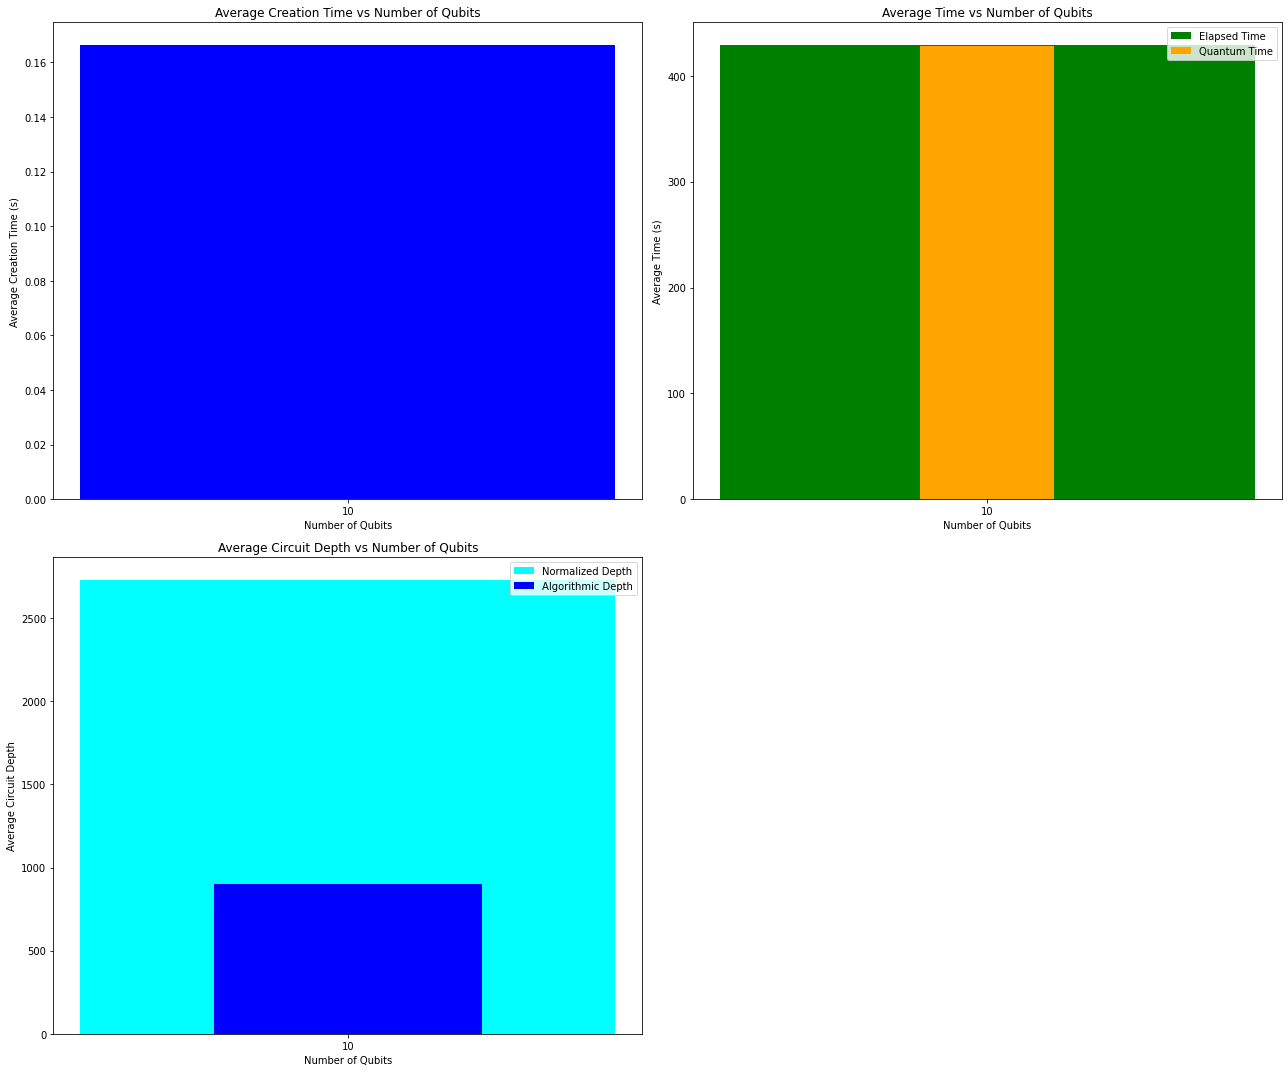

avg_num_qubits_values [10]


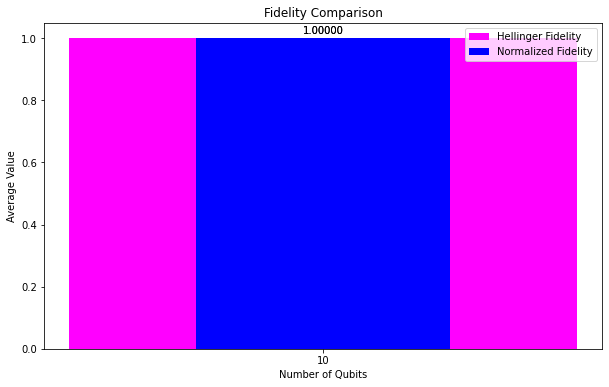

{10: [1.0]}
{10: [1.0]}
[1.0]
[1.0]


In [6]:
backend = BasicAer.get_backend('dm_simulator')
#################### Benchmark Loop        

# Execute program with default parameters
def run (min_qubits=3, max_circuits=1, max_qubits=10, num_shots=100, method = 1):
    print(f"{benchmark_name} ({method}) Benchmark - Qiskit")

    # Each method has a different minimum amount of qubits to run and a certain multiple of qubits that can be run
    qubit_multiple = 2                  #Standard for Method 2 and 3

    max_qubits = max(max_qubits, min_qubits)        # max must be >= min

    if method == 1:
        min_qubits = max(min_qubits, 10)            # need min of 10
        qubit_multiple = 4
    elif method ==2:
        min_qubits = max(min_qubits, 7)             # need min of 7
    elif method == 3:
        min_qubits = max(min_qubits,6)              # need min of 6

    #skip_qubits = max(1, skip_qubits)
    
    if max_qubits < min_qubits:
        print(f"Max number of qubits {max_qubits} is too low to run method {method} of {benchmark_name}")
        return

    global max_ckts
    max_ckts = max_circuits

    global min_qbits,max_qbits,skp_qubits

    min_qbits = min_qubits
    max_qbits = max_qubits
    skp_qubits = qubit_multiple

    creation_times = []
    elapsed_times = []
    quantum_times = []
    circuit_depths = []
    transpiled_depths = []
    fidelity_data = {}
    Hf_fidelity_data = {}

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, qubit_multiple):

        input_size = num_qubits - 1

        if method == 1: num_bits = int((num_qubits -2)/4)
        elif method == 2: num_bits = int((num_qubits -3)/2)
        elif method == 3: num_bits = int((num_qubits -2)/2)

        fidelity_data[num_qubits] = []
        Hf_fidelity_data[num_qubits] = []

        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (input_size), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")

        for _ in range(num_circuits):

            base = 1
            while base == 1:
                # Ensure N is a number using the greatest bit
                number = np.random.randint(2 ** (num_bits - 1) + 1, 2 ** num_bits)
                order = np.random.randint(2, number)
                base = generate_base(number, order)

            # Checking if generated order can be reduced. Can also run through prime list in shors utils
            if order % 2 == 0: order = 2
            if order % 3 == 0: order = 3

            number_order = (number, order)

            if verbose: print(f"Generated {number=}, {base=}, {order=}")

            # create the circuit for given qubit size and order, store time metric
            ts = time.time()
            qc = ShorsAlgorithm(number, base, method=method, verbose=verbose).reverse_bits()
            #creation time
            creation_time = time.time() - ts
            creation_times.append(creation_time)
            print(f"qc of {num_qubits} qubits of type {type}")
            print(qc)

            # collapse the 4 sub-circuit levels used in this benchmark (for qiskit)
            qc = qc.decompose().decompose().decompose().decompose()

            # Calculate circuit depth
            depth = calculate_circuit_depth(qc)
            circuit_depths.append(depth)

            # Calculate transpiled circuit depth
            transpiled_depth = calculate_transpiled_depth(qc,basis_selector)
            transpiled_depths.append(transpiled_depth)
            
            #execution
            ts = time.time()
            job = execute(qc, backend, shots=num_shots, **options)
            result = job.result()
            elapsed_time = time.time() - ts
            elapsed_times.append(elapsed_time)

            # Calculate quantum processing time (excluding creation time)
            quantum_time = result.results[0].running_time_taken
            quantum_times.append(quantum_time)
            print(result.results[0])
            #ensemble probability
            prob = result.results[0].data.partial_probability
            print(prob)
            counts = prob

            for key in counts.keys():
               counts[key] = int(counts[key] * num_shots)
            print("counts=",counts)

            if  method == 1:
                num_bits = int((num_qubits - 2) / 4)
            elif method == 2:
                num_bits = int((num_qubits - 3) / 2)
            elif method == 3:
                num_bits = int((num_qubits - 2) / 2)

            # Only classical data qubits are important and removing first auxiliary qubit from count
            if method == 2:
                temp_counts = {}
                for key, item in counts.items():
                    temp_counts[key[2:]] = item
                counts = temp_counts

            # generate correct distribution
            correct_dist = expected_shor_dist(num_bits, order, num_shots)

            #fidelity
            fidelity_dict = polarization_fidelity(counts, correct_dist)
            print("fidelity_dict =",fidelity_dict)
            
            fidelity_data[num_qubits].append(fidelity_dict['fidelity'])
            Hf_fidelity_data[num_qubits].append(fidelity_dict['hf_fidelity'])

        print(f"... number of gates, depth = {num_gates}, {depth}")

    ##########
    
    # print the last circuit created
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nControlled Ua Operator 'cUa' ="); print(CUA_ if CUA_ != None else " ... too large!")
    print("\nControlled Multiplier Operator 'cMULTamodN' ="); print(CMULTAMODN_ if CMULTAMODN_!= None else " ... too large!")
    print("\nControlled Modular Adder Operator 'ccphiamodN' ="); print(CCPHIADDMODN_ if CCPHIADDMODN_ != None else " ... too large!")
    print("\nPhi Adder Operator '\u03C6ADD' ="); print(PHIADD_ if PHIADD_ != None else " ... too large!")
    print("\nQFT Circuit ="); print(QFT_ if QFT_ != None else "  ... too large!")

    return creation_times, elapsed_times, quantum_times, circuit_depths, transpiled_depths, fidelity_data, Hf_fidelity_data

# Execute the benchmark program, accumulate metrics, and calculate circuit depths
creation_times, elapsed_times, quantum_times, circuit_depths,transpiled_depths, fidelity_data, Hf_fidelity_data = run()
    
# Define the range of qubits for the x-axis
num_qubits_range = range(min_qbits, max_qbits+1,skp_qubits)
print("num_qubits_range =",num_qubits_range)

# Calculate average creation time, elapsed time, quantum processing time, and circuit depth for each number of qubits
avg_creation_times = [np.mean(creation_times[i:i+max_ckts]) for i in range(0, len(creation_times), max_ckts)]
avg_elapsed_times = [np.mean(elapsed_times[i:i+max_ckts]) for i in range(0, len(elapsed_times), max_ckts)]
avg_quantum_times = [np.mean(quantum_times[i:i+max_ckts]) for i in range(0, len(quantum_times), max_ckts)]
avg_circuit_depths = [np.mean(circuit_depths[i:i+max_ckts]) for i in range(0, len(circuit_depths), max_ckts)]
avg_transpiled_depths = [np.mean(transpiled_depths[i:i+max_ckts]) for i in range(0, len(transpiled_depths), max_ckts)]

print(f"avg_creation_times={avg_creation_times}")
# Plot histograms for average creation time, average elapsed time, average quantum processing time, and average circuit depth versus the number of qubits
plt.figure(figsize=(18, 15))

plt.subplot(2, 2, 1)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_creation_times, color='blue')
plt.xlabel('Number of Qubits')
plt.ylabel('Average Creation Time (s)')
plt.title('Average Creation Time vs Number of Qubits')

plt.subplot(2, 2, 2)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_elapsed_times, color='green',label ='Elapsed Time')
plt.bar(num_qubits_range, avg_quantum_times, color='orange',label ='Quantum Time', width=0.2)
plt.xlabel('Number of Qubits')
plt.ylabel('Average Time (s)')
plt.title('Average Time vs Number of Qubits')
plt.legend()

plt.subplot(2, 2, 3)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_transpiled_depths, color='cyan', label='Normalized Depth', width=0.4)  # Adjust width here
plt.bar(num_qubits_range, avg_circuit_depths, color='blue', label='Algorithmic Depth', width=0.2)  # Adjust width here
plt.xlabel('Number of Qubits')
plt.ylabel('Average Circuit Depth')
plt.title('Average Circuit Depth vs Number of Qubits')
plt.legend()


plt.tight_layout()
plt.show()

# Calculate the fidelity data
plot_data(fidelity_data, Hf_fidelity_data, "Fidelity Comparison")